In [1]:
import sys

import pandas as pd
import numpy as np
#import matplotlib as plt
#from matplotlib import pyplot
#import scipy as sp
#from xgboost import XGBClassifier
import sklearn
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import CategoricalNB

from sklearn import svm

from sklearn.metrics import mean_squared_error, r2_score

from sklearn import preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,recall_score,precision_score, f1_score

For this problem tha dataset consisted of the games played over the course of 5 years, between 2011/2012 until 2016/2017, of the five major european leagues, suming to a total of 10112 games. There are two mandatory input features for this problem, the home team and the away team, so we can estimate how offensive and defensive each team is and thus predict if the total of goals scored will be greater than 2.5 or not. Like the previous problem, the season of the game will also be included because of the team evolution throughout the years. Two relevant features that would make our model better would be, firstly, the odds of each result, because it takes into account external factors not covered by this dataset, and, secondly, the odds of both teams score, because this taken into account the agreesive/offensive part of each team, the only problem is that only 10% of the games have this information, so for the sake of this problem our data will only contain games with full information about the odds of each possible outcome.

In [2]:
filename = 'ginf.csv'
games = pd.read_csv('./data/' + filename)
selected = games[games.odd_over.notnull() & games.odd_under.notnull()][['fthg','ftag','ht','at','season','odd_over','odd_under','odd_bts','odd_bts_n']].copy()
selected

,fthg,ftag,ht,at,season,odd_over,odd_under,odd_bts,odd_bts_n
9135,0,1,Bastia,Paris Saint-Germain,2017,1.92,2.12,2.25,1.74
9136,2,2,AS Monaco,Guingamp,2017,2.14,1.83,2.05,1.93
9137,3,2,Caen,Lorient,2017,2.28,1.78,1.95,2.02
9138,1,1,Southampton,Watford,2017,2.15,1.84,2.05,1.93
9139,1,0,Montpellier,Angers,2017,2.80,1.53,2.40,1.70
...,...,...,...,...,...,...,...,...,...
10107,2,2,Genoa,Crotone,2017,1.95,2.03,2.03,1.86
10108,2,0,Chelsea,Hull,2017,1.54,2.68,2.40,1.66
10109,4,0,AS Monaco,Lorient,2017,1.53,3.08,1.80,2.25
10110,0,0,Real Betis,Sporting Gijon,2017,2.20,1.89,2.05,1.86


In this section we will process the data in order to transform this into a classification problem. The output will be a binary data, two values, **under** for less than a total of 2.5 goals and **over** for more than 2.5 goals.
The final input data will not have how many goals each team scored otherwise an accuracy of 100% would be achieved.

In [3]:
selected['total'] = selected['fthg'] + selected['ftag']

col = 'total'
conditions = [selected[col] < 2.5 , selected[col] > 2.5]
choices = ['0','1']
selected['total'] = np.select(conditions,choices,default=np.nan)
selected = selected.iloc[:,2:]
selected = selected[['total','ht','at','odd_over','odd_under','odd_bts','odd_bts_n']]
selected

,total,ht,at,odd_over,odd_under,odd_bts,odd_bts_n
9135,0,Bastia,Paris Saint-Germain,1.92,2.12,2.25,1.74
9136,1,AS Monaco,Guingamp,2.14,1.83,2.05,1.93
9137,1,Caen,Lorient,2.28,1.78,1.95,2.02
9138,0,Southampton,Watford,2.15,1.84,2.05,1.93
9139,0,Montpellier,Angers,2.80,1.53,2.40,1.70
...,...,...,...,...,...,...,...
10107,1,Genoa,Crotone,1.95,2.03,2.03,1.86
10108,0,Chelsea,Hull,1.54,2.68,2.40,1.66
10109,1,AS Monaco,Lorient,1.53,3.08,1.80,2.25
10110,0,Real Betis,Sporting Gijon,2.20,1.89,2.05,1.86


In [4]:
'''data = pd.DataFrame();
data['total'] = 0
for i, j in temp.iterrows(): 
    if j['ht'] not in data.columns:
            data[j['ht']] = 0
    if j['at'] not in data.columns:
        data[j['at']] = 0
    if j['season'] not in data.columns:
        data[j['season']] = 0
    data = data.append({'total': j['total'], j['season']: 1, j['ht'] : 1 , 
                        j['at']: -1 , 'odd_under' : j['odd_under'], 'odd_over' : j['odd_over'],
                       'odd_bts' : j['odd_bts'], 'odd_bts_n' : j['odd_bts_n']}, ignore_index=True)

data'''


"data = pd.DataFrame();\ndata['total'] = 0\nfor i, j in temp.iterrows(): \n    if j['ht'] not in data.columns:\n            data[j['ht']] = 0\n    if j['at'] not in data.columns:\n        data[j['at']] = 0\n    if j['season'] not in data.columns:\n        data[j['season']] = 0\n    data = data.append({'total': j['total'], j['season']: 1, j['ht'] : 1 , \n                        j['at']: -1 , 'odd_under' : j['odd_under'], 'odd_over' : j['odd_over'],\n                       'odd_bts' : j['odd_bts'], 'odd_bts_n' : j['odd_bts_n']}, ignore_index=True)\n\ndata"

In [5]:
data = pd.get_dummies(selected,columns=['ht','at'])
data

,total,odd_over,odd_under,odd_bts,odd_bts_n,ht_AC Milan,ht_AS Monaco,ht_AS Nancy Lorraine,ht_AS Roma,ht_Alaves,...,at_Toulouse,at_US Pescara,at_Udinese,at_Valencia,at_VfL Wolfsburg,at_Villarreal,at_Watford,at_Werder Bremen,at_West Brom,at_West Ham
9135,0,1.92,2.12,2.25,1.74,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9136,1,2.14,1.83,2.05,1.93,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9137,1,2.28,1.78,1.95,2.02,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9138,0,2.15,1.84,2.05,1.93,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9139,0,2.80,1.53,2.40,1.70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10107,1,1.95,2.03,2.03,1.86,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10108,0,1.54,2.68,2.40,1.66,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10109,1,1.53,3.08,1.80,2.25,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10110,0,2.20,1.89,2.05,1.86,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data = data.replace(np.nan, 0)
X = data.iloc[:,1:]
y = data.iloc[:,:1]
y = np.ravel(y)
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
y

(977, 200)
(977,)


array(['0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0',
       '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1',
       '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1',
       '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1',
       '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1',
       '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '0',
       '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1',
       '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0',
       '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0',
       '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1',
       '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0',
       '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0

In [7]:
pipeline = make_pipeline(KNeighborsClassifier())

hyperparameters = { 'kneighborsclassifier__n_neighbors' : [15, 40, 100],
                  'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree'],
                  'kneighborsclassifier__weights': ['uniform','distance']}


clf = GridSearchCV(pipeline, hyperparameters, cv=10)

In [8]:
#clf = RandomForestClassifier(n_estimators=200)
#clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(30,20,3), random_state=1 , max_iter = 1000)
clf = KNeighborsClassifier(n_neighbors=91, algorithm='auto',weights='uniform');
#clf = RandomForestClassifier(n_estimators=400)
#clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=91, p=2,
                     weights='uniform')

In [9]:
accuracy = clf.score(X_test, y_test)
#y_pred = clf.predict_proba(X_test)
#predict = clf.predict(X_test)
#y_total = y_train.count()
#y_positive = y_train.sum()
#print('The training set contains {} examples (games) of which {} are positives .'.format(y_total, y_positive))
print('The accuracy of classifying is {:.2f} %'.format(accuracy*100))

The accuracy of classifying is 57.96 %


In [17]:
models = []

KNNhyperparameters = {'kneighborsclassifier__n_neighbors' : [41,81, 101]}
SVMhyperparameters = {'svc__kernel' : ['linear','rbf','poly','sigmoid'],
                      'svc__gamma' : ['auto','scale']}
MLPhyperparameters = {'mlpclassifier__solver' : ['adam','sgd'] , 
                      'mlpclassifier__hidden_layer_sizes' : [(30,20,10,5,2) , (5,5,5,5,5)]}
RFThyperparameters = {'randomforestclassifier__n_estimators' : [50,100,200]}
GPChyperparameters = {'gaussianprocessclassifier__warm_start' : [True,False] , 
                      'gaussianprocessclassifier__n_restarts_optimizer' : [0,1,2,4,5] , 
                      'gaussianprocessclassifier__max_iter_predict' : [50,100,200,400]}


models.append(('GPC' , GaussianProcessClassifier() , GPChyperparameters ))
models.append(('KNN' , KNeighborsClassifier(), KNNhyperparameters))
models.append(('SVC' , svm.SVC(), SVMhyperparameters))
models.append(('MLP' , MLPClassifier(max_iter = 4000) , MLPhyperparameters ))
models.append(('RFT' , RandomForestClassifier() , RFThyperparameters ))

for name, model, hyper in models:
    pipeline = make_pipeline(model)
    clf = GridSearchCV(pipeline, hyper)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Model name: " + name)
    #print("R2 score: {:.4f}".format(r2_score(y_test, y_pred)))
    #print("Mean square error: {:.4f}".format(mean_squared_error(y_test, y_pred)))
    #print('Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
    #print('Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))
    #print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('F-measure: {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
    print('The accuracy of classifying is {:.3f} %'.format(clf.score(X_test, y_test)*100))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred))
    print('Report:')
    print(classification_report(y_test,y_pred))
    print(clf.best_params_)
    print("\n")

Model name: GPC
F-measure: 0.5959
The accuracy of classifying is 59.592 %
Confusion Matrix:
[[57 62]
 [37 89]]
Report:
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       119
           1       0.59      0.71      0.64       126

    accuracy                           0.60       245
   macro avg       0.60      0.59      0.59       245
weighted avg       0.60      0.60      0.59       245

{'gaussianprocessclassifier__max_iter_predict': 50, 'gaussianprocessclassifier__n_restarts_optimizer': 0, 'gaussianprocessclassifier__warm_start': True}


Model name: KNN
F-measure: 0.5673
The accuracy of classifying is 56.735 %
Confusion Matrix:
[[45 74]
 [32 94]]
Report:
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       119
           1       0.56      0.75      0.64       126

    accuracy                           0.57       245
   macro avg       0.57      0.56      0.55       245
weighted

c:\users\gustavo\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model name: RFT
F-measure: 0.5143
The accuracy of classifying is 51.429 %
Confusion Matrix:
[[64 55]
 [64 62]]
Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       119
           1       0.53      0.49      0.51       126

    accuracy                           0.51       245
   macro avg       0.51      0.51      0.51       245
weighted avg       0.52      0.51      0.51       245

{'randomforestclassifier__n_estimators': 50}




In [22]:

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

#definition of useful methods
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

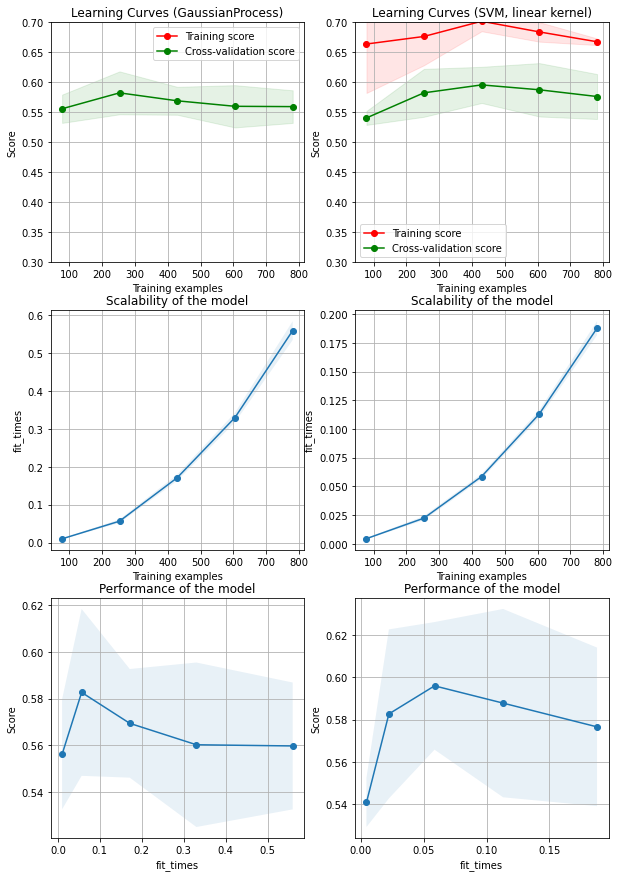

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (GaussianProcess)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = GaussianProcessClassifier(max_iter_predict = 50, n_restarts_optimizer = 0, warm_start = True)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.3, 0.7),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, linear kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = svm.SVC(gamma = 'scale', kernel = 'rbf')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.3, 0.7),
                    cv=cv, n_jobs=4)

plt.show()